In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import imageio
import itertools
import shutil
import os
import random
from glob import glob
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Input, Activation, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D, Concatenate
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import SGD, Adam
from keras import backend as K 
from keras.utils import plot_model
from keras import layers as KL
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input

%matplotlib inline

Using TensorFlow backend.


In [2]:
class Data_Processing():
    @staticmethod
    def make_working_directories(wd,tr,val,dir1,dir2):
        '''Makes working directory and training & validation directories within working directories.
        After that makes folder with 0 and 1 classification within training and validation directories.
        arguments:- 1. working_directory_name, 2. trainig_directory_name, 3. validation_directory_name,
        4. directory_name_with_class_1, 5. directory_name_with_class_0'''
        # Because I'm sampling a subset of images, I will make separate directory
        # for the sampled images and not mix with the original ones.
        working_dir = wd

        if os.path.exists(working_dir) and os.path.isdir(working_dir):
            shutil.rmtree(working_dir)

        os.mkdir(working_dir)
        # Now make train_dir and validation_dir within working_dir
        train_dir = os.path.join(working_dir, tr)
        validation_dir = os.path.join(working_dir, val)
        os.mkdir(train_dir)
        os.mkdir(validation_dir)

        # now make normal and cancer subfolders inside train directory
        cancer = os.path.join(train_dir, dir1)
        normal = os.path.join(train_dir, dir2)
        os.mkdir(cancer)
        os.mkdir(normal)

        # now make normal and cancer subfolders inside validation directory
        cancer = os.path.join(validation_dir, dir1)
        normal = os.path.join(validation_dir, dir2)
        os.mkdir(cancer)
        os.mkdir(normal)
        print("Finished making directories!")
        return
    
    def print_images(tdd, df,column,n_images):
        '''Prints sample images.'''
        unique_categories = (df.groupby([column])[column].unique()).index
        fig, ax = plt.subplots(nrows=len(unique_categories), ncols=n_images,
                          figsize=(5*n_images, 5*len(unique_categories)))
    
        for i, category in enumerate(unique_categories):
            im = df[df[column]==category].sample(n_images) # n_images is also the sample size
            for j in range(0,n_images):
                file = tdd + im.iloc[j]['id'] + '.tif'
                img = cv2.imread(file)
                ax[i,j].imshow(img, resample=True, cmap='gray')
                color = ['red' if df.iloc[i].label == 1 else 'green'][0]
                ax[i,j].set_title(category, fontsize=36, color=color)
        plt.tight_layout()
        plt.show()
        return
    
    def sampling(df, sample_size):
        '''Takes a subset of images from unbalanced dataset to make balanced
        dataset to work with.'''
        df0 = df[df['label'] == 0].sample(sample_size, random_state=42)
        df1 = df[df['label'] == 1].sample(sample_size, random_state=42)
        
        # now concatenate the dataframes
        df_train = pd.concat([df0, df1], axis=0).reset_index(drop=True)

        # shuffle
        df_train = shuffle(df_train)
        
        return df_train
    
    def split_data(df_train):
        '''Splits data into training and validation sets.'''
        df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42,
                                     stratify=df_train['label'])
        
        # If I don't set the id below as index of the df, it will give error while attaching
        # .tif to the image name
        #df.set_index('id', inplace=True)
        
        train_list = list(df_train['id'])
        valid_list = list(df_valid['id'])
        
        return df_train, df_valid, train_list, valid_list
    
    def copy_data(lst, source_directory,target_directory):
        '''Copies data and puts them into respective directories inside working directory.'''
        for image in lst:
            file_name = image + '.tif'
            target = df.loc[image, 'label']
            if target == 0:
                label = 'normal'
            elif target == 1:
                label = 'cancer'
            
            image_source = os.path.join(source_directory, file_name)
            image_destination = os.path.join(target_directory, label, file_name)
            
            # copy the image from source folder to the destination folder
            shutil.copyfile(image_source, image_destination)
            
        print("Finished copying data in ", target_directory, " !")
            
        return
    
    
class Cancer:
    @staticmethod
    def build_model1(height, width, depth):
        kernel_size = (2,2)
        pool_size = (2,2)
        first_filters = 32
        second_filters = 32
        third_filters = 64
        
        dropout_dense = 0.5
        
        input_shape = (height, width, depth)
        
        model = Sequential() 
        model.add(Conv2D(first_filters, kernel_size=kernel_size, input_shape = input_shape))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 

        model.add(Conv2D(second_filters, kernel_size, activation ='relu')) 
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        

        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 

        model.add(Flatten()) 
        model.add(Dense(64, activation = 'relu')) 
        model.add(Dropout(dropout_dense)) 
        model.add(Dense(2, activation = 'sigmoid')) 
        
        
        model.summary()
        
        model.compile(Adam(lr=0.0001, decay=0.00001),loss='binary_crossentropy',  metrics=['accuracy'])

        return model
    
    
    def build_model2(height, width, depth):
        kernel_size = (2,2)
        pool_size = (2,2)
        first_filters = 32
        second_filters = 32
        third_filters = 64
        fourth_filters = 128
        
        dropout_dense = 0.5
        
        input_shape = (height, width, depth)
        
        model = Sequential() 
        model.add(Conv2D(first_filters, kernel_size=kernel_size, input_shape = input_shape))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 

        model.add(Conv2D(second_filters, kernel_size, activation ='relu')) 
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        

        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 
        
        model.add(Conv2D(fourth_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(fourth_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(fourth_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 

        model.add(Flatten()) 
        model.add(Dense(64, activation = 'relu')) 
        model.add(Dropout(dropout_dense)) 
        model.add(Dense(2, activation = 'sigmoid'))  
        
        model.summary()
        
        model.compile(Adam(lr=0.0001, decay=0.00001),loss='binary_crossentropy',  metrics=['accuracy'])
        
        return model
    
    def build_model3(height, width, depth):
        kernel_size = (2,2)
        pool_size = (2,2)
        first_filters = 32
        second_filters = 32
        third_filters = 64
        fourth_filters = 128
        
        dropout_dense = 0.5
        
        input_shape = (height, width, depth)
        
        model = Sequential() 
        model.add(Conv2D(first_filters, kernel_size=kernel_size, input_shape = input_shape))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 

        model.add(Conv2D(second_filters, kernel_size, activation ='relu')) 
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        

        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 
        
        model.add(Conv2D(fourth_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(fourth_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(fourth_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 

        model.add(Flatten()) 
        model.add(Dense(64, activation = 'relu')) 
        model.add(Dropout(dropout_dense))  
        model.add(Dense(2, activation = 'softmax')) 
              
        model.summary()
        
        model.compile(Adam(lr=0.0001, decay=0.00001),loss='binary_crossentropy',  metrics=['accuracy'])

        return model

    
    def build_model4(height, width, depth):
        kernel_size = (3,3)
        pool_size= (2,2)
        first_filters = 32
        second_filters = 64
        third_filters = 128

        dropout_conv = 0.3
        dropout_dense = 0.3
        
        input_shape = (height, width, depth)

        model = Sequential()
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = input_shape))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 
        model.add(Dropout(dropout_conv))

        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Flatten())
        model.add(Dense(256, activation = "relu"))
        model.add(Dropout(dropout_dense))
        model.add(Dense(2, activation = "softmax"))

        model.summary()
        
        model.compile(Adam(lr=0.0001, decay=0.00001),loss='binary_crossentropy',  metrics=['accuracy'])

        return model
    
    def build_model5(height, width, depth):
        kernel_size = (2,2)
        pool_size = (2,2)
        first_filters = 32
        second_filters = 64
        third_filters = 128
        fourth_filters = 128

        
        dropout_conv = 0.3
        dropout_dense = 0.3
        
        input_shape = (height, width, depth)

        model = Sequential()
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = input_shape))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 
        model.add(Dropout(dropout_conv))

        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))
        
        model.add(Conv2D(fourth_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(fourth_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(fourth_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Flatten())
        model.add(Dense(256, activation = "relu"))
        model.add(Dropout(dropout_dense))
        model.add(Dense(2, activation = "softmax"))
        
        model.summary()
        
        model.compile(Adam(lr=0.0001, decay=0.00001),loss='binary_crossentropy',  metrics=['accuracy'])

        return model
    
    def build_model6(height, width, depth):
        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context
        
        
        input_shape = (height, width, depth)
        resnet = ResNet50(include_top=False, weights='imagenet', 
                          input_shape=input_shape)
        
        inputs = Input((height, width, depth))
        outputs = GlobalAveragePooling2D()(resnet(inputs))
        outputs = Dropout(0.5)(outputs)
        outputs = Dense(2, activation='sigmoid')(outputs)
        
        model = Model(inputs, outputs)
        
        model.summary()
        
        model.compile(Adam(lr=0.0001, decay=0.00001),loss='binary_crossentropy',  metrics=['accuracy'])
        
        return model
    
    
    def build_model7(height, width, depth):
        input_shape = (height, width, depth)
        NasM = NASNetMobile(include_top=False, input_shape=input_shape, weights=None)
        inputs = Input((height, width, depth))
        x = NasM(inputs)
        out1 = GlobalMaxPooling2D()(x)
        out2 = GlobalAveragePooling2D()(x)
        out3 = Flatten()(x)
        out = Concatenate(axis=-1)([out1, out2, out3])
        out = Dropout(0.5)(out)
        out = Dense(2, activation="sigmoid", name="3_")(out)
        model = Model(inputs, out)

        model.summary()
        
        model.compile(Adam(lr=0.0001, decay=0.00001),loss='binary_crossentropy',  metrics=['accuracy'])
        
        return model

    
    def build_datagen(tp, vp, tstp, imsize, bsize):
        datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2)
        
        train_datagen = datagen.flow_from_directory(tp, target_size=(imsize,imsize),
                                                   batch_size=bsize, class_mode='categorical')
        
        validation_datagen = datagen.flow_from_directory(vp, target_size=(imsize,imsize),
                                                   batch_size=bsize, class_mode='categorical')
        
        #test_datagen = datagen.flow_from_directory(tstp, target_size=(imsize,imsize),
        #                                           batch_size=1, class_mode='binary',
        #                                          shuffle=False)
        
        test_datagen = datagen.flow_from_directory(vp, target_size=(imsize,imsize),
                                                   batch_size=1, class_mode='categorical',
                                                  shuffle=False)
        
        return train_datagen, validation_datagen, test_datagen
    
    def callback_list(model):
        checkpoint = ModelCheckpoint(model, monitor='val_accuracy', verbose=1,
                                    save_best_only=True, mode='max')
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5, patience=2,
                                     verbose=1, mode='max', min_lr=0.00001)
        callback_list = [checkpoint, reduce_lr]
        return callback_list



In [3]:
print('Files in the working directory ====>', os.listdir('./working_dir'))
print('Files in the working/train directory ====>', os.listdir('./working_dir/train_dir'))
print('Files in the working/validation directory ====>', os.listdir('./working_dir/validation_dir'))

Files in the working directory ====> ['.DS_Store', 'train_dir', 'validation_dir']
Files in the working/train directory ====> ['.DS_Store', 'cancer', 'normal']
Files in the working/validation directory ====> ['cancer', 'normal']


In [4]:
TRAIN_DATA_DIRECTORY = '../data/train/'
TRAIN_LABEL = '../data/train_labels.csv'
TEST_DATA_DIRECTORY = '../data/test/'
df_sampled = pd.read_csv('df_sampled.csv')
df_sampled.head()

,id,label
0,402ca4eccdf378e8f5233873bbc08b38ea8993f2,0
1,710e80026b86a6ab187b33e415ead47f26faedda,1
2,2b2388ceb0e433831a454265a0a980293532ecae,0
3,bc76c7d156128e6c724139a938e2b6ae7fb18ee9,1
4,c1e1ddd35d445c842c34f6c47122d64778dfddf7,0


#### Now split the train and validation sets and put them into their respective folders

The `stratify` parameter makes a split so that the porportion of values in the sample produced will be the same as the proportion of values provided to parameter `stratify`.
For example, if variable `y` is binary categorical variable with values `0` and `1` and there are 25% of zeros adn 75% of ones, `stratify=y` will make sure that your random split has 25% of `0`'s and 75% of `1`'s.

In [5]:
df_train, df_valid, train_list, valid_list = Data_Processing.split_data(df_sampled)

print('df_train shape', df_train.shape)
print('df_validation_shape', df_valid.shape)

df_train shape (32000, 2)
df_validation_shape (8000, 2)


In [6]:
print('Number of files in working_dir/train_dir/cancer ====>', \
      len(os.listdir('working_dir/train_dir/cancer')))
print('Number of files in working_dir/train_dir/normal ====>', \
      len(os.listdir('working_dir/train_dir/normal')))
print('Number of files in working_dir/validation_dir/cancer ====>', \
      len(os.listdir('working_dir/validation_dir/cancer')))
print('Number of files in working_dir/validation_dir/normal ====>', \
      len(os.listdir('working_dir/validation_dir/normal')))

Number of files in working_dir/train_dir/cancer ====> 16000
Number of files in working_dir/train_dir/normal ====> 16000
Number of files in working_dir/validation_dir/cancer ====> 4000
Number of files in working_dir/validation_dir/normal ====> 4000


In [7]:
IMAGE_SIZE = 96
train_path = 'working_dir/train_dir'
validation_path = 'working_dir/validation_dir'
test_path = 'data/test'

num_train_samples = len(df_train)
num_valid_samples = len(df_valid)

batch_size = 10

train_datagen, validation_datagen, test_datagen = Cancer.build_datagen(train_path,validation_path,
                                                                       test_path, IMAGE_SIZE,batch_size)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [8]:
from keras.models import load_model
my_model1 = load_model('./models/new_model1.h5')
my_model2 = load_model('./models/new_model2.h5')
my_model3 = load_model('./models/new_model3.h5')
my_model4 = load_model('./models/new_model4.h5')
my_model5 = load_model('./models/new_model5.h5')

In [9]:
val_loss_dict = {}
val_acc_dict = {}

val_loss, val_acc = my_model1.evaluate_generator(test_datagen, steps=len(df_valid))

val_loss_dict['model1'] = val_loss
val_acc_dict['model1'] = val_acc

val_loss, val_acc = my_model2.evaluate_generator(test_datagen, steps=len(df_valid))

val_loss_dict['model2'] = val_loss
val_acc_dict['model2'] = val_acc

val_loss, val_acc = my_model3.evaluate_generator(test_datagen, steps=len(df_valid))

val_loss_dict['model3'] = val_loss
val_acc_dict['model3'] = val_acc

val_loss, val_acc = my_model4.evaluate_generator(test_datagen, steps=len(df_valid))

val_loss_dict['model4'] = val_loss
val_acc_dict['model4'] = val_acc

val_loss, val_acc = my_model5.evaluate_generator(test_datagen, steps=len(df_valid))

val_loss_dict['model5'] = val_loss
val_acc_dict['model5'] = val_acc

In [10]:
index = [0]
val_loss_df = pd.DataFrame(val_loss_dict, index=index)
val_acc_df = pd.DataFrame(val_acc_dict, index=index)
val_loss_df = val_loss_df.T
val_loss_df.columns = ['val_loss']
val_loss_df

,val_loss
model1,0.023002
model2,0.018761
model3,0.014563
model4,0.025661
model5,0.056837


In [11]:
val_acc_df = val_acc_df.T
val_acc_df.columns = ['val_acc']
val_acc_df

,val_acc
model1,0.865250
model2,0.869687
model3,0.871375
model4,0.838375
model5,0.853500


In [12]:
val_loss_df.reset_index

<bound method DataFrame.reset_index of         val_loss
model1  0.023002
model2  0.018761
model3  0.014563
model4  0.025661
model5  0.056837>

In [13]:
val_acc_df.reset_index

<bound method DataFrame.reset_index of          val_acc
model1  0.865250
model2  0.869687
model3  0.871375
model4  0.838375
model5  0.853500>

In [14]:
val_loss_val_acc_df = val_loss_df.join(val_acc_df, how='outer')
val_loss_val_acc_df

,val_loss,val_acc
model1,0.023002,0.865250
model2,0.018761,0.869687
model3,0.014563,0.871375
model4,0.025661,0.838375
model5,0.056837,0.853500


In [15]:
predictions1_x = my_model1.predict_generator(test_datagen, steps=len(df_valid), verbose=1)
predictions2_x = my_model2.predict_generator(test_datagen, steps=len(df_valid), verbose=1)
predictions3_x = my_model3.predict_generator(test_datagen, steps=len(df_valid), verbose=1)
predictions4_x = my_model4.predict_generator(test_datagen, steps=len(df_valid), verbose=1)
predictions5_x = my_model5.predict_generator(test_datagen, steps=len(df_valid), verbose=1)

8000/8000 [==============================] - 51s 6ms/step


In [16]:
df_predictions1 = pd.DataFrame(predictions1_x, columns=['normal', 'cancer'])
df_predictions2 = pd.DataFrame(predictions2_x, columns=['normal', 'cancer'])
df_predictions3 = pd.DataFrame(predictions3_x, columns=['normal', 'cancer'])
df_predictions4 = pd.DataFrame(predictions4_x, columns=['normal', 'cancer'])
df_predictions5 = pd.DataFrame(predictions5_x, columns=['normal', 'cancer'])

In [17]:
roc_auc_score_dict = {}


# get the true labels of the images
y_true = test_datagen.classes

# Get the predicted labels as probabilities
y_pred = df_predictions1['cancer']

print(roc_auc_score(y_true, y_pred))

roc_auc_score_dict['model1'] = roc_auc_score(y_true, y_pred)

y_pred = df_predictions2['cancer']

print(roc_auc_score(y_true, y_pred))

roc_auc_score_dict['model2'] = roc_auc_score(y_true, y_pred)

y_pred = df_predictions3['cancer']

print(roc_auc_score(y_true, y_pred))

roc_auc_score_dict['model3'] = roc_auc_score(y_true, y_pred)

y_pred = df_predictions4['cancer']

print(roc_auc_score(y_true, y_pred))

roc_auc_score_dict['model4'] = roc_auc_score(y_true, y_pred)

y_pred = df_predictions5['cancer']

print(roc_auc_score(y_true, y_pred))

roc_auc_score_dict['model5'] = roc_auc_score(y_true, y_pred)

0.9400665624999999
0.94524878125
0.9458989375
0.9211320937499999
0.92509978125


In [18]:
index = [0]
roc_auc_scores_df = pd.DataFrame(roc_auc_score_dict, index=index)
roc_auc_scores_df = roc_auc_scores_df.T
roc_auc_scores_df.columns = ['roc_auc_scores']
roc_auc_scores_df

,roc_auc_scores
model1,0.940067
model2,0.945249
model3,0.945899
model4,0.921132
model5,0.925100


In [19]:
val_loss_val_acc_roc_auc_scores_df = val_loss_val_acc_df.join(roc_auc_scores_df, how='outer')
val_loss_val_acc_roc_auc_scores_df

,val_loss,val_acc,roc_auc_scores
model1,0.023002,0.865250,0.940067
model2,0.018761,0.869687,0.945249
model3,0.014563,0.871375,0.945899
model4,0.025661,0.838375,0.921132
model5,0.056837,0.853500,0.925100


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [21]:
test_labels = test_datagen.classes
cm1 = confusion_matrix(test_labels, predictions1_x.argmax(axis=1))
cm2 = confusion_matrix(test_labels, predictions2_x.argmax(axis=1))
cm3 = confusion_matrix(test_labels, predictions3_x.argmax(axis=1))
cm4 = confusion_matrix(test_labels, predictions4_x.argmax(axis=1))
cm5 = confusion_matrix(test_labels, predictions5_x.argmax(axis=1))
cm_plot_labels = ['cancer', 'normal']

Confusion matrix, without normalization
[[3293  707]
 [ 384 3616]]


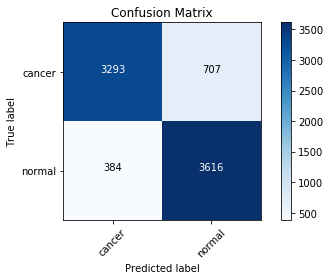

In [22]:
plot_confusion_matrix(cm1, cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[3443  557]
 [ 438 3562]]


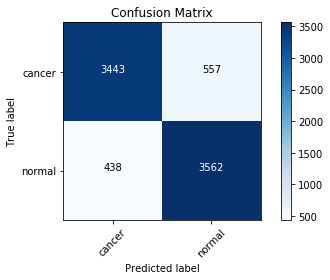

In [23]:
plot_confusion_matrix(cm2, cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[3393  607]
 [ 407 3593]]


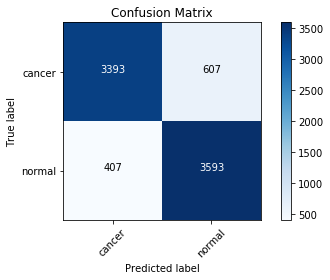

In [24]:
plot_confusion_matrix(cm3, cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[3526  474]
 [ 844 3156]]


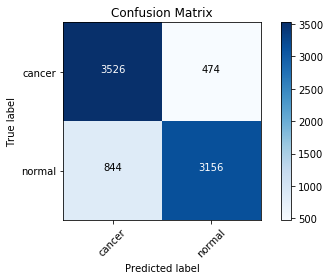

In [25]:
plot_confusion_matrix(cm4, cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[3461  539]
 [ 651 3349]]


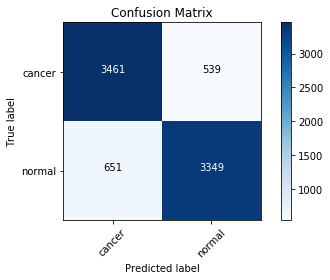

In [26]:
plot_confusion_matrix(cm5, cm_plot_labels, title='Confusion Matrix')